In [ ]:
# Disables Weights & Biases logging so the Trainer does not ask for an API key (via Github)
import os
os.environ["WANDB_DISABLED"] = "true"




In [ ]:
!pip install planetterp transformers torch pandas scikit-learn

import planetterp
import pandas as pd
import torch


In [ ]:
# Retrieves professor reviews from PlanetTerp using correct full names
professors = [
    "Nelson Padua-Perez",
    "Timothy Pilachowski",
    "Pedram Sadeghian",
    "Stefan Doboszczak",
    "Jonathan Fernandes"
]

all_reviews = []

for prof in professors:
    print(f"Fetching: {prof}")
    data = planetterp.professor(prof, reviews=True)

    # If PlanetTerp returns any  error, this skips
    if not isinstance(data, dict) or "reviews" not in data:
        print(" -> ERROR: No reviews found")
        continue

    # Extracts each review
    for r in data["reviews"]:
        all_reviews.append({
            "professor": prof,
            "review_text": r.get("review", ""),
            "rating": r.get("rating", None)
        })

print(f"Collected {len(all_reviews)} total reviews.")

df = pd.DataFrame(all_reviews)
df.head()

Fetching: Nelson Padua-Perez
Fetching: Timothy Pilachowski
Fetching: Pedram Sadeghian
Fetching: Stefan Doboszczak
Fetching: Jonathan Fernandes
Collected 798 total reviews.


,professor,review_text,rating
0,Nelson Padua-Perez,Nelson is a great guy! His personality is so n...,4
1,Nelson Padua-Perez,Nelson is absolutely and unequivocally the wor...,1
2,Nelson Padua-Perez,People told me Nelson was awesome before I cho...,3
3,Nelson Padua-Perez,Nelson is a wonderfully funny professor who re...,5
4,Nelson Padua-Perez,"In my opinion, Nelson is a solid CS professor....",4


In [ ]:
# Removes blank reviews and convert ratings to integers
df = df.dropna(subset=["review_text", "rating"])
df = df[df["review_text"].str.strip() != ""]
df["rating"] = df["rating"].astype(int)
df.head()


,professor,review_text,rating
0,Nelson Padua-Perez,Nelson is a great guy! His personality is so n...,4
1,Nelson Padua-Perez,Nelson is absolutely and unequivocally the wor...,1
2,Nelson Padua-Perez,People told me Nelson was awesome before I cho...,3
3,Nelson Padua-Perez,Nelson is a wonderfully funny professor who re...,5
4,Nelson Padua-Perez,"In my opinion, Nelson is a solid CS professor....",4


In [ ]:
# Loads tokenizer and convert all review text to tokenized model inputs
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

texts = df["review_text"].tolist()
labels = df["rating"].tolist()

encodings = tokenizer(
    texts,
    truncation=True,
    padding=True
)


In [ ]:
# PyTorch Dataset for tokenized reviews and labels
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx] - 1)  # convert 1–5 to 0–4
        return item

dataset = ReviewDataset(encodings, labels)


In [ ]:
# Loads the DistilBERT model set up to predict ratings from 1 to 5
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=5
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Defines how the model trains and creates the Trainer that runs fine-tuning
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    logging_steps=20,
    weight_decay=0.01,
    save_strategy="no"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# Trains the DistilBERT model on the collected review dataset
trainer.train()

Step,Training Loss
20,1.560000
40,1.298400
60,1.143600
80,1.121300
100,1.068000
120,0.915200
140,0.904600
160,0.804100
180,0.785200
200,0.780200


TrainOutput(global_step=200, training_loss=1.0380583858489991, metrics={'train_runtime': 76.8168, 'train_samples_per_second': 20.777, 'train_steps_per_second': 2.604, 'total_flos': 211429279272960.0, 'train_loss': 1.0380583858489991, 'epoch': 2.0})

In [ ]:
# prediction helper that generates the model’s star ratings
def predict_rating(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
    pred = torch.argmax(outputs.logits, dim=1).item()
    return pred + 1

df["predicted"] = df["review_text"].apply(predict_rating)
df.head()


,professor,review_text,rating,predicted
0,Nelson Padua-Perez,Nelson is a great guy! His personality is so n...,4,4
1,Nelson Padua-Perez,Nelson is absolutely and unequivocally the wor...,1,1
2,Nelson Padua-Perez,People told me Nelson was awesome before I cho...,3,4
3,Nelson Padua-Perez,Nelson is a wonderfully funny professor who re...,5,5
4,Nelson Padua-Perez,"In my opinion, Nelson is a solid CS professor....",4,5


In [ ]:
# Evaluates the model’s performance using accuracy and mean absolute error
from sklearn.metrics import accuracy_score, mean_absolute_error

accuracy = accuracy_score(df["rating"], df["predicted"])
mae = mean_absolute_error(df["rating"], df["predicted"])

print("Accuracy:", accuracy)
print("MAE:", mae)


Accuracy: 0.731829573934837
MAE: 0.32456140350877194


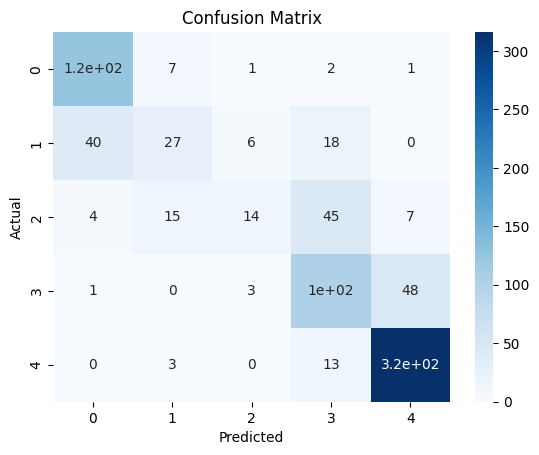

In [ ]:

# Visualization that hows how predicted ratings compare to actual ratings
# using a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(df["rating"], df["predicted"])

sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
